In [ ]:
!pip install split-folders

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import splitfolders
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [ ]:
print(tf.__version__)

2.6.2


In [ ]:
data_dir = '../input/all-brain-datset/all_dataset'
batch_size=32
image_size=224

In [ ]:
splitfolders.ratio(data_dir+ "/Training", output='brain-tumor-classification-mri', ratio=(0.8,0.1,0.1))

Copying files: 3264 files [00:18, 173.67 files/s]


In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  "./brain-tumor-classification-mri/train",
  shuffle=True,
  image_size=(image_size, image_size),
  batch_size=batch_size
)

Found 2609 files belonging to 4 classes.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  "./brain-tumor-classification-mri/val",
  shuffle=False,
  image_size=(image_size, image_size),
  batch_size=batch_size
)

Found 325 files belonging to 4 classes.


In [ ]:
test_ds = tf.keras.utils.image_dataset_from_directory(
  "./brain-tumor-classification-mri/test",
  shuffle=False,
  image_size=(image_size, image_size),
  batch_size=batch_size
)

Found 330 files belonging to 4 classes.


In [ ]:
class_names = test_ds.class_names
print(class_names)

['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']


In [ ]:
def my_tf_round(x, decimals = 0):
    multiplier = tf.constant(10**decimals, dtype=x.dtype)
    return tf.round(x * multiplier) / multiplier

In [ ]:
normalization_layer1 = tf.keras.layers.Rescaling(1./255)
normalization_layer2 = tf.keras.layers.Normalization(mean=[0.5, 0.5, 0.5], 
                      variance=[np.square(0.5), 
                                np.square(0.5), 
                                np.square(0.5)])

2022-04-16 16:12:58.372752: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


-1.0 0.8801


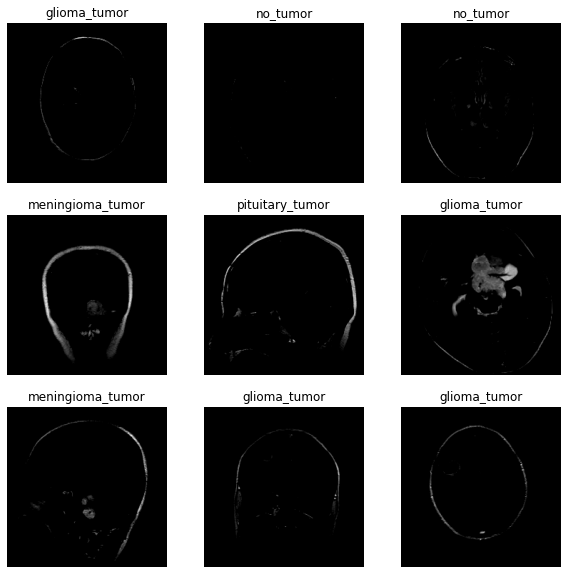

In [ ]:
train_ds_normalized = train_ds.map(lambda x, y: (my_tf_round(normalization_layer2(normalization_layer1(x)),4) , y))
image_batch, labels_batch = next(iter(train_ds_normalized))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))
plt.figure(figsize=(10, 10))
for images, labels in train_ds_normalized:
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy())
    plt.title(class_names[labels[i]])
    plt.axis("off")

-1.0 0.8801


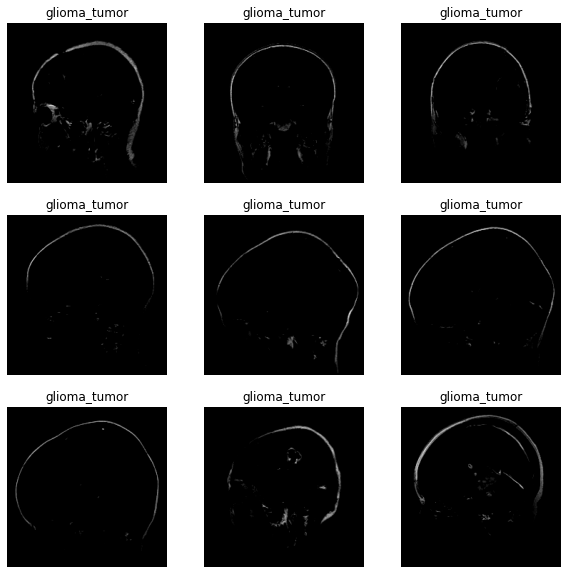

In [ ]:
val_ds_normalized = val_ds.map(lambda x, y: (my_tf_round(normalization_layer2(normalization_layer1(x)),4) , y))
image_batch, labels_batch = next(iter(val_ds_normalized))

print(np.min(first_image), np.max(first_image))
plt.figure(figsize=(10, 10))
for images, labels in val_ds_normalized.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy())
    plt.title(class_names[labels[i]])
    plt.axis("off")

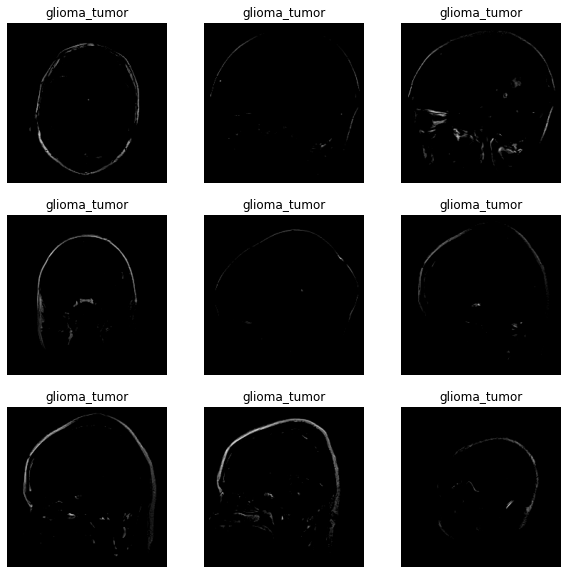

In [ ]:
test_ds_normalized = test_ds.map(lambda x, y: (my_tf_round(normalization_layer2(normalization_layer1(x)),4) , y))
image_batch, labels_batch = next(iter(test_ds_normalized))
plt.figure(figsize=(10, 10))
for images, labels in test_ds_normalized.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy())
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
y_test = [label for images, labels in test_ds_normalized for label in labels.numpy()]

In [ ]:
def display_report_and_matrix(y_pred, model):
    print(f'Test {model} Tensorflow and Keras')
   
    y_prediction = np.argmax(y_pred,axis=1)
    report = classification_report(y_test, y_prediction, target_names=class_names)
    print(f'{report}')

    fig, ax = plt.subplots(figsize=(7,7)) 
    ax.set_title(f'Confusion Matrix {model} Tensorflow and Keras')
    cm = confusion_matrix(y_test,y_prediction)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_names)
    disp.plot(cmap='Blues', ax=ax)

In [ ]:
def display_plot(history, model):
    plt.figure(figsize=(14, 8))
    tab_plot = [{
                  "id": 1,
                  "variables":['accuracy', 'val_accuracy'],
                  "labels":['Training Accuracy', 'Validation Accuracy'],
                  "legend":'lower right',
                  "title":f'Accuracy Tensorflow and Keras - {model}',
                  "ylabel":'Accuracy'
              },{ 
                  "id": 2,
                  "variables":['loss', 'val_loss'],
                  "labels":['Training Loss', 'Validation Loss'],
                  "legend":'upper right',
                  "title":f'Loss Tensorflow and Keras - {model}',
                  "ylabel":'Loss'
              }]
    epochs_range = range(25)
    for tab in tab_plot: 
          plt.subplot(1, 2, tab['id'])
          plt.plot(epochs_range, history.history[tab['variables'][0]], label=tab['labels'][0], marker='o', markerfacecolor='green',color='green')
          plt.plot(epochs_range, history.history[tab['variables'][1]], label=tab['labels'][1], marker='o', markerfacecolor='blue',color='blue')
          plt.legend(loc=tab['legend'])
          plt.title(tab['title'])
          plt.xlabel('Epochs')
          plt.ylabel(tab['ylabel'])
    plt.show()

In [ ]:
from tensorflow.keras.applications import MobileNetV2 
mobilenet =  MobileNetV2(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3),alpha=1)

In [ ]:
model = mobilenet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.2)(model)
model = tf.keras.layers.Dense(4,activation='softmax')(model)
model = tf.keras.models.Model(inputs=mobilenet.input, outputs = model)

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
print('Train Mobilenetv2 Tensorflow and Keras')
history_mobilenet_v2 = model.fit(train_ds_normalized, validation_data=(val_ds_normalized), epochs=25)

Train Mobilenetv2 Tensorflow and Keras
Epoch 1/25
82/82 [==============================] - 19s 187ms/step - loss: 0.5703 - accuracy: 0.7811 - val_loss: 0.9648 - val_accuracy: 0.6000
Epoch 2/25
82/82 [==============================] - 15s 178ms/step - loss: 0.1443 - accuracy: 0.9555 - val_loss: 0.8649 - val_accuracy: 0.6431
Epoch 3/25
82/82 [==============================] - 15s 184ms/step - loss: 0.0462 - accuracy: 0.9916 - val_loss: 0.8166 - val_accuracy: 0.7046
Epoch 4/25
82/82 [==============================] - 15s 178ms/step - loss: 0.0252 - accuracy: 0.9958 - val_loss: 0.7341 - val_accuracy: 0.7354
Epoch 5/25
82/82 [==============================] - 15s 179ms/step - loss: 0.0191 - accuracy: 0.9973 - val_loss: 0.7584 - val_accuracy: 0.7354
Epoch 6/25
82/82 [==============================] - 15s 179ms/step - loss: 0.0133 - accuracy: 0.9977 - val_loss: 0.6282 - val_accuracy: 0.7754
Epoch 7/25
82/82 [==============================] - 15s 179ms/step - loss: 0.0092 - accuracy: 0.9989 - 

Test Mobilenetv2 Tensorflow and Keras
                  precision    recall  f1-score   support

    glioma_tumor       0.92      0.89      0.91        94
meningioma_tumor       0.90      0.91      0.90        95
        no_tumor       1.00      0.94      0.97        50
 pituitary_tumor       0.94      0.99      0.96        91

        accuracy                           0.93       330
       macro avg       0.94      0.93      0.94       330
    weighted avg       0.93      0.93      0.93       330



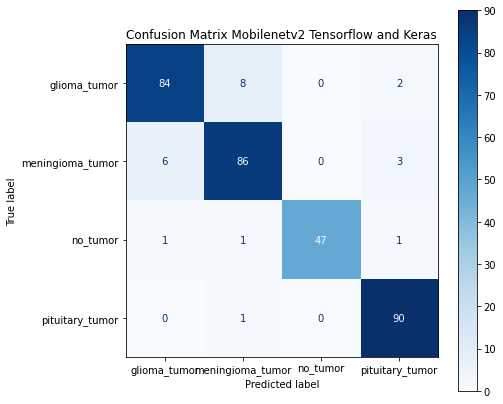

In [ ]:
y_pred_mobilenet_v2 = model.predict(test_ds_normalized)
display_report_and_matrix(y_pred_mobilenet_v2, 'Mobilenetv2')

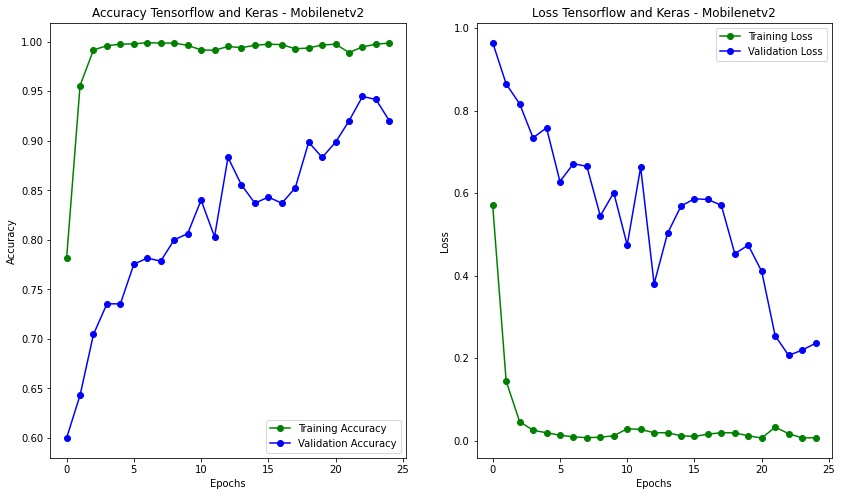

In [ ]:
display_plot(history_mobilenet_v2, 'Mobilenetv2')